# Extraemos todas las features del paciente 5   

In [1]:
#Importación de librerías
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mne import io
from FVfunctions import getMeData, pot4signals, BANDAS
from features_stats import stats_features
from dataset_reader import get_seizure_events, get_seizure_array

In [6]:
DATASET_DIR = "../eeg_dataset"
edf_names = []
seizure_events = []

for directory in os.listdir(DATASET_DIR):
    print('='*50)
    print(f"{directory: ^50}")
    print('='*50)
    
    for filename in os.listdir(os.path.join(DATASET_DIR, directory)):
        if '.edf' in filename:
            edf_names.append(f"{DATASET_DIR}/{directory}/{filename}")
        elif '.txt' in filename:
            new_seizures = get_seizure_events(f"{DATASET_DIR}/{directory}/{filename}")
            seizure_events.extend(new_seizures)
            for event in new_seizures:
                print('\n'.join([f"{key}: {val}" for key, val in event.items()]))
                print()

print(edf_names)

                       PN01                       
seizure_number: 1
file_name: PN01-1.edf
registration_start_time: 19.00.44
registration_end_time: 08.29.41
seizure_start_time: 21.51.02
seizure_end_time: 21.51.56

seizure_number: 2
file_name: PN01-1.edf
registration_start_time: 19.00.44
registration_end_time: 08.29.41
seizure_start_time: 07.53.17
seizure_end_time: 07.54.31

                       PN05                       
seizure_number: 2
file_name: PN05-2.edf
registration_start_time: 06.46.02
registration_end_time: 09.19.47
seizure_start_time: 08.45.25
seizure_end_time: 08.46.00

seizure_number: 3
file_name: PN05-3.edf
registration_start_time: 06.01.23
registration_end_time: 08.06.57
seizure_start_time: 07.55.19
seizure_end_time: 07.55.49

seizure_number: 4
file_name: PN05-4.edf
registration_start_time: 06.38.35
registration_end_time: 08.00.23
seizure_start_time: 07.38.43
seizure_end_time: 07.39.22

                       PN09                       
seizure_number: 1
file_name: PN0

In [7]:
channels = ['EEG T3', 'EEG T5', 'EEG F7', 'EEG F3', 'EEG C3', 'EEG P3']
segments = []
labels = []
fs = None

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for edf in edf_names:
        # Paso 1: duracion de señal y seizures
        name = edf.split('/')[-1]
        this_seizure_events = [seiz for seiz in seizure_events if seiz["file_name"]==name]
        
        if len(this_seizure_events) == 0:
            print('nada en', name)
            continue
            
        ex_seiz = this_seizure_events[0]
        mtx_t_reg = np.array([ex_seiz['registration_start_time'], ex_seiz['registration_end_time']])
        arr_mtx_t_epi = get_seizure_array(this_seizure_events)
    
        # Paso 2: extraemos la señal
        raw = io.read_raw_edf(edf)
        print('\n\n')
        if fs is None:
            fs = raw.info['sfreq']
        raw_filt = raw.pick(channels)
        data_namefilt = raw_filt.get_data() * 1e6
    
        # Paso 3: sacamos segmentos
        new_seg, new_label = getMeData(data_namefilt[0], 
                                       mtx_t_reg, 
                                       arr_mtx_t_epi, 
                                       winlen=5, 
                                       proportion=0.5)
        segments.append(new_seg)
        labels.append(new_label)
        

segments_arr = np.concatenate(segments)
labels_arr = np.concatenate(labels)

Extracting EDF parameters from C:\Users\gonza\OneDrive\Documentos\ITBA\TP FINAL PSIB\eeg_dataset\PN01\PN01-1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Extracting EDF parameters from C:\Users\gonza\OneDrive\Documentos\ITBA\TP FINAL PSIB\eeg_dataset\PN05\PN05-2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Extracting EDF parameters from C:\Users\gonza\OneDrive\Documentos\ITBA\TP FINAL PSIB\eeg_dataset\PN05\PN05-3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Extracting EDF parameters from C:\Users\gonza\OneDrive\Documentos\ITBA\TP FINAL PSIB\eeg_dataset\PN05\PN05-4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Extracting EDF parameters from C:\Users\gonza\OneDrive\Documentos\ITBA\TP FINAL PSIB\eeg_dataset\PN09\PN09-1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure.

In [8]:
segments_arr.shape

(487, 2560)

In [9]:
# Potencia
more_pot = pot4signals(segments_arr, fs, divisor=1)
pot_names = [f"potAbs{band.capitalize()}" for band in BANDAS.keys()]

# Estadistica
stat_data = stats_features(segments_arr)
stats_names = list(stat_data.values())[:-1]
more_stat = stat_data["matriz de features stat"]

# Feature fector
data_fv = np.hstack((more_pot, more_stat))
columnas = pot_names + stats_names
df_fv = pd.DataFrame(data_fv, columns=columnas)
df_fv

,potAbsDelta,potAbsTheta,potAbsAlpha,potAbsBeta,potAbsGamma,kurtosis,RMS,skewness,media,desvio estandar
0,224.468204,49.063105,14.648940,33.638190,28.857683,0.591504,17.996653,-0.352057,-5.763255,17.048883
1,28.784997,2248.650147,107.377205,101.383314,97.414858,-0.888499,53.738004,-0.302102,-1.969028,53.701918
2,861.532917,3556.901047,171.972027,60.928052,42.466373,-1.183761,68.511380,-0.446759,2.709397,68.457785
3,2081.142124,406.701510,82.083284,134.108784,163.100911,-0.797705,53.462038,-0.421898,-0.601242,53.458657
4,567.047535,224.175886,86.558806,53.817700,16.894085,-0.468791,29.548931,-0.317221,3.799468,29.303641
...,...,...,...,...,...,...,...,...,...,...
482,47.987498,11.920564,8.384573,5.768031,4.066788,2.297060,9.876487,-1.340477,-1.074054,9.817912
483,66.640676,16.552313,11.517604,25.508494,41.896944,0.277824,16.931781,-0.014402,-1.323342,16.879987
484,85.290623,42.500849,10.430781,31.352849,35.633767,1.011186,16.733378,-0.049506,0.566395,16.723790
485,15.286387,3.895992,2.133297,4.851584,4.451669,2.568408,8.222890,-1.197084,1.956171,7.986821


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC, SVC
import seaborn as sns

In [11]:
train_x, test_x, train_y, test_y = train_test_split(df_fv, labels_arr, test_size=0.2, random_state=0)

0.7755102040816326


C:\Users\gonza\miniconda3\envs\psivenv\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


<Axes: >

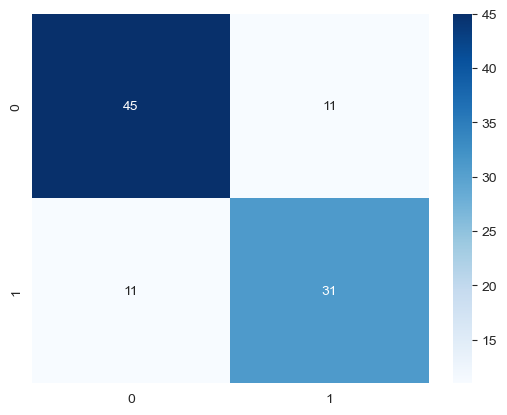

In [12]:
# testeamos en un modelo lineal
linear_model = LinearSVC(dual=True)
linear_model.fit(train_x, train_y)
predictions = linear_model.predict(test_x)
print(accuracy_score(test_y, predictions))
cm = confusion_matrix(test_y, predictions)
sns.heatmap(cm, cmap='Blues', annot=True)

0.6836734693877551


<Axes: >

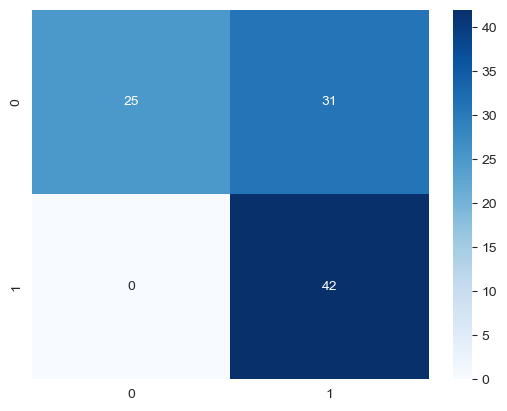

In [14]:
# kernel
rbf_model = SVC(kernel='rbf')
rbf_model.fit(train_x, train_y)
rbf_pred = rbf_model.predict(test_x)
print(accuracy_score(test_y, rbf_pred))
cm_rbf = confusion_matrix(test_y, rbf_pred)
sns.heatmap(cm_rbf, annot=True, cmap='Blues')